In [1]:
# Install required libraries
!pip install open3d numpy matplotlib tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.4 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7

In [6]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import open3d as o3d

In [3]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

# Paths to models and datasets
# Paths to validation data and models
validation_data_path = "/content/drive/MyDrive/validation_point_cloud.ply"
validation_labels_path = "/content/drive/MyDrive/validation_labels.txt"
pointpillars_model_path = "/content/drive/MyDrive/PointPillars_Object_Detection.h5"
centerpoint_model_path = "/content/drive/MyDrive/CenterPoint_Detection.h5"
pointrcnn_model_path = "/content/drive/MyDrive/PointRCNN_Detection.h5"

Mounted at /content/drive


In [4]:
# Load validation point cloud
def load_point_cloud(file_path):
    """
    Load the point cloud from a .ply file using Open3D.
    """
    point_cloud = o3d.io.read_point_cloud(file_path)
    if len(point_cloud.points) == 0:
        raise ValueError("Point cloud file is empty or invalid.")
    points = np.asarray(point_cloud.points)
    return points

# Normalize points
def normalize_points(points):
    min_vals = np.min(points, axis=0)
    max_vals = np.max(points, axis=0)
    normalized_points = (points - min_vals) / (max_vals - min_vals)
    return normalized_points

# Load validation labels
def load_labels(file_path):
    with open(file_path, 'r') as f:
        labels = np.array([int(line.strip()) for line in f if not line.startswith("#")])
    return labels

# Preprocess points for general models
def preprocess_points(points, labels=None, num_features=3, pillar_size=3):
    """
    Preprocess points and optionally trim to match labels.
    """
    if labels is not None:
        points = points[:len(labels)]
    num_points = points.shape[0]
    reshaped_points = points[:num_points - (num_points % pillar_size)].reshape((-1, num_features, pillar_size))
    return reshaped_points

def preprocess_points_for_pointrcnn(points, labels):
    """
    Preprocess points to match the expected input shape of the PointRCNN model
    and ensure alignment with the number of labels.
    """
    # Trim points to match the number of labels
    points = points[:len(labels)]
    num_points = points.shape[0]

    # Add a dummy feature (e.g., intensity = 0) to make the input shape (None, 4)
    dummy_feature = np.zeros((num_points, 1))
    reshaped_points = np.hstack([points, dummy_feature])

    return reshaped_points

In [7]:
# Load validation point cloud and labels
validation_points = load_point_cloud(validation_data_path)
validation_points = normalize_points(validation_points)
validation_labels = load_labels(validation_labels_path)

print(f"Validation points shape: {validation_points.shape}")
print(f"Validation labels shape: {validation_labels.shape}")

Validation points shape: (3100, 3)
Validation labels shape: (3100,)


In [8]:
# Preprocess for the models
processed_validation_points = preprocess_points(validation_points, validation_labels)

# One-hot encode validation labels
num_classes = max(validation_labels) + 1  # Determine the number of classes from labels
one_hot_validation_labels = tf.keras.utils.to_categorical(validation_labels[:processed_validation_points.shape[0]], num_classes=num_classes)
print(f"One-hot encoded validation labels shape: {one_hot_validation_labels.shape}")

# Load models
pointpillars_model = tf.keras.models.load_model(pointpillars_model_path)
centerpoint_model = tf.keras.models.load_model(centerpoint_model_path)
pointrcnn_model = tf.keras.models.load_model(pointrcnn_model_path)

One-hot encoded validation labels shape: (1033, 9)


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model, points, labels):
    """
    Evaluate the model and calculate performance metrics.
    Convert one-hot encoded labels back to class indices if necessary.
    """
    # Predict class probabilities
    predictions = model.predict(points)

    # Convert predicted probabilities to class indices
    predicted_classes = np.argmax(predictions, axis=1)

    # Convert one-hot encoded true labels to class indices if needed
    if labels.ndim > 1:  # If labels are one-hot encoded
        labels = np.argmax(labels, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(labels, predicted_classes)
    precision = precision_score(labels, predicted_classes, average='weighted')
    recall = recall_score(labels, predicted_classes, average='weighted')
    f1 = f1_score(labels, predicted_classes, average='weighted')

    return accuracy, precision, recall, f1, predicted_classes

In [11]:
results = {}

# Evaluate PointPillars
accuracy, precision, recall, f1, predicted_pp = evaluate_model(
    pointpillars_model, processed_validation_points, one_hot_validation_labels
)
results["PointPillars"] = [accuracy, precision, recall, f1]

# Evaluate CenterPoint
accuracy, precision, recall, f1, predicted_cp = evaluate_model(
    centerpoint_model, processed_validation_points, one_hot_validation_labels
)
results["CenterPoint"] = [accuracy, precision, recall, f1]

# Preprocess validation points for PointRCNN
processed_validation_points_rcnn = preprocess_points_for_pointrcnn(validation_points, validation_labels)

# Re-encode the labels to match the processed points
one_hot_validation_labels_rcnn = tf.keras.utils.to_categorical(
    validation_labels[:processed_validation_points_rcnn.shape[0]], num_classes=num_classes
)

# Evaluate PointRCNN
accuracy, precision, recall, f1, predicted_rcnn = evaluate_model(
    pointrcnn_model, processed_validation_points_rcnn, one_hot_validation_labels_rcnn
)
results["PointRCNN"] = [accuracy, precision, recall, f1]

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


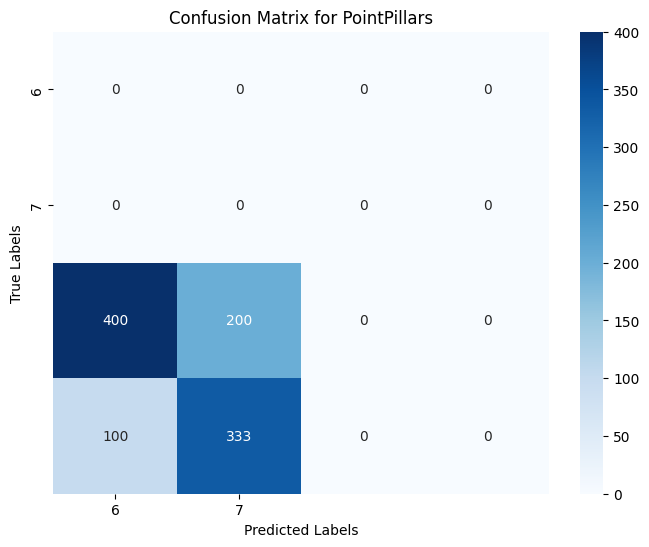

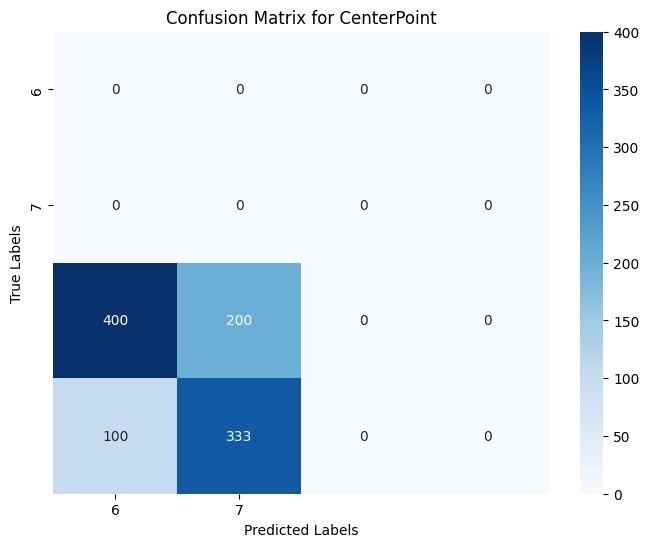

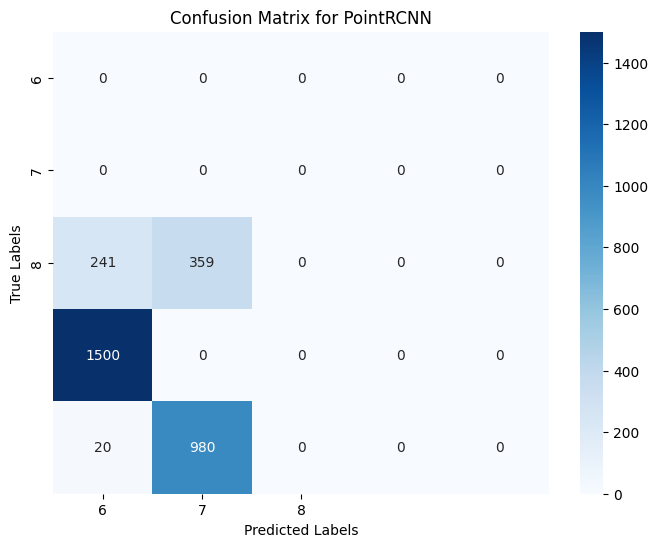

In [15]:
# Define the plot_confusion_matrix function
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_labels, predicted_labels, model_name):
    """
    Plot the confusion matrix for a given set of true and predicted labels.
    """
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Adjust labels to match predictions
def adjust_labels_for_predictions(labels, predictions):
    """
    Adjust the labels to match the size of predictions.
    """
    return labels[:len(predictions)]

# Adjust labels for each model
adjusted_labels_pp = adjust_labels_for_predictions(validation_labels, predicted_pp)
adjusted_labels_cp = adjust_labels_for_predictions(validation_labels, predicted_cp)
adjusted_labels_rcnn = adjust_labels_for_predictions(validation_labels, predicted_rcnn)

# Plot confusion matrix for each model
plot_confusion_matrix(adjusted_labels_pp, predicted_pp, "PointPillars")
plot_confusion_matrix(adjusted_labels_cp, predicted_cp, "CenterPoint")
plot_confusion_matrix(adjusted_labels_rcnn, predicted_rcnn, "PointRCNN")